# Post-processing tests

## Common part

In [1]:
# Move to root directory
import os
try :
    FIX_PATH += 1  # type: ignore
except NameError :
    FIX_PATH = 0
    print('> move to ', end='')
    %cd ../..
finally:
    print(f'current path: {os.getcwd()}')


> move to /home/valentingoldite/Documents/Stage_Fin_Etude/python/gan-facies-modeling
current path: /home/valentingoldite/Documents/Stage_Fin_Etude/python/gan-facies-modeling


In [2]:
# Import cell
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import torch

from gan_facies.metrics.metric import evaluate, wasserstein_distances as wdists
from gan_facies.utils.configs import GlobalConfig
from gan_facies.gan.uncond_sagan.modules import (UncondSADiscriminator,
                                                 UncondSAGenerator)
from gan_facies.data.process import to_img_grid, color_data_np
from gan_facies.utils.post_process import (clip_by_indicator,
                                           clip_indicator_eval,
                                           postprocess_erode_dilate)

### Load models and usefull variables

In [3]:
device = 'cuda'  # 'cuda' boost the speed of the inference
config_path = f'gan_facies/configs/exp/usagan128.yaml'
step = 224000
indicator_path = 'datasets/gansim_ds128_co2_us8_indicators.json'

# Create list of indicators from the json file
indicators_df = pd.read_json(indicator_path)
indicators_ref = [{}, {}]
for key in indicators_df:
    indicators_ref[0][key] = indicators_df[key][0]
    indicators_ref[1][key] = indicators_df[key][1]

# Load the model
config = GlobalConfig.build_from_argv(
    fallback=config_path,
    verbose=False)

gen = UncondSAGenerator(n_classes=3, model_config=config.model)
run_name = config.run_name
gen.load_state_dict(torch.load(
    f'res/{run_name}/models/generator_step_{step}.pth'
    ))
gen = gen.to(device)

connectivity = config.metrics.connectivity
unit_component_size = config.metrics.unit_component_size
batch_size = config.data.test_batch_size


Performing post-processing for modified parameters...


### Compute indicators

 -> Generating images for metrics calculation: 5120 images
 -> Computing indicators...


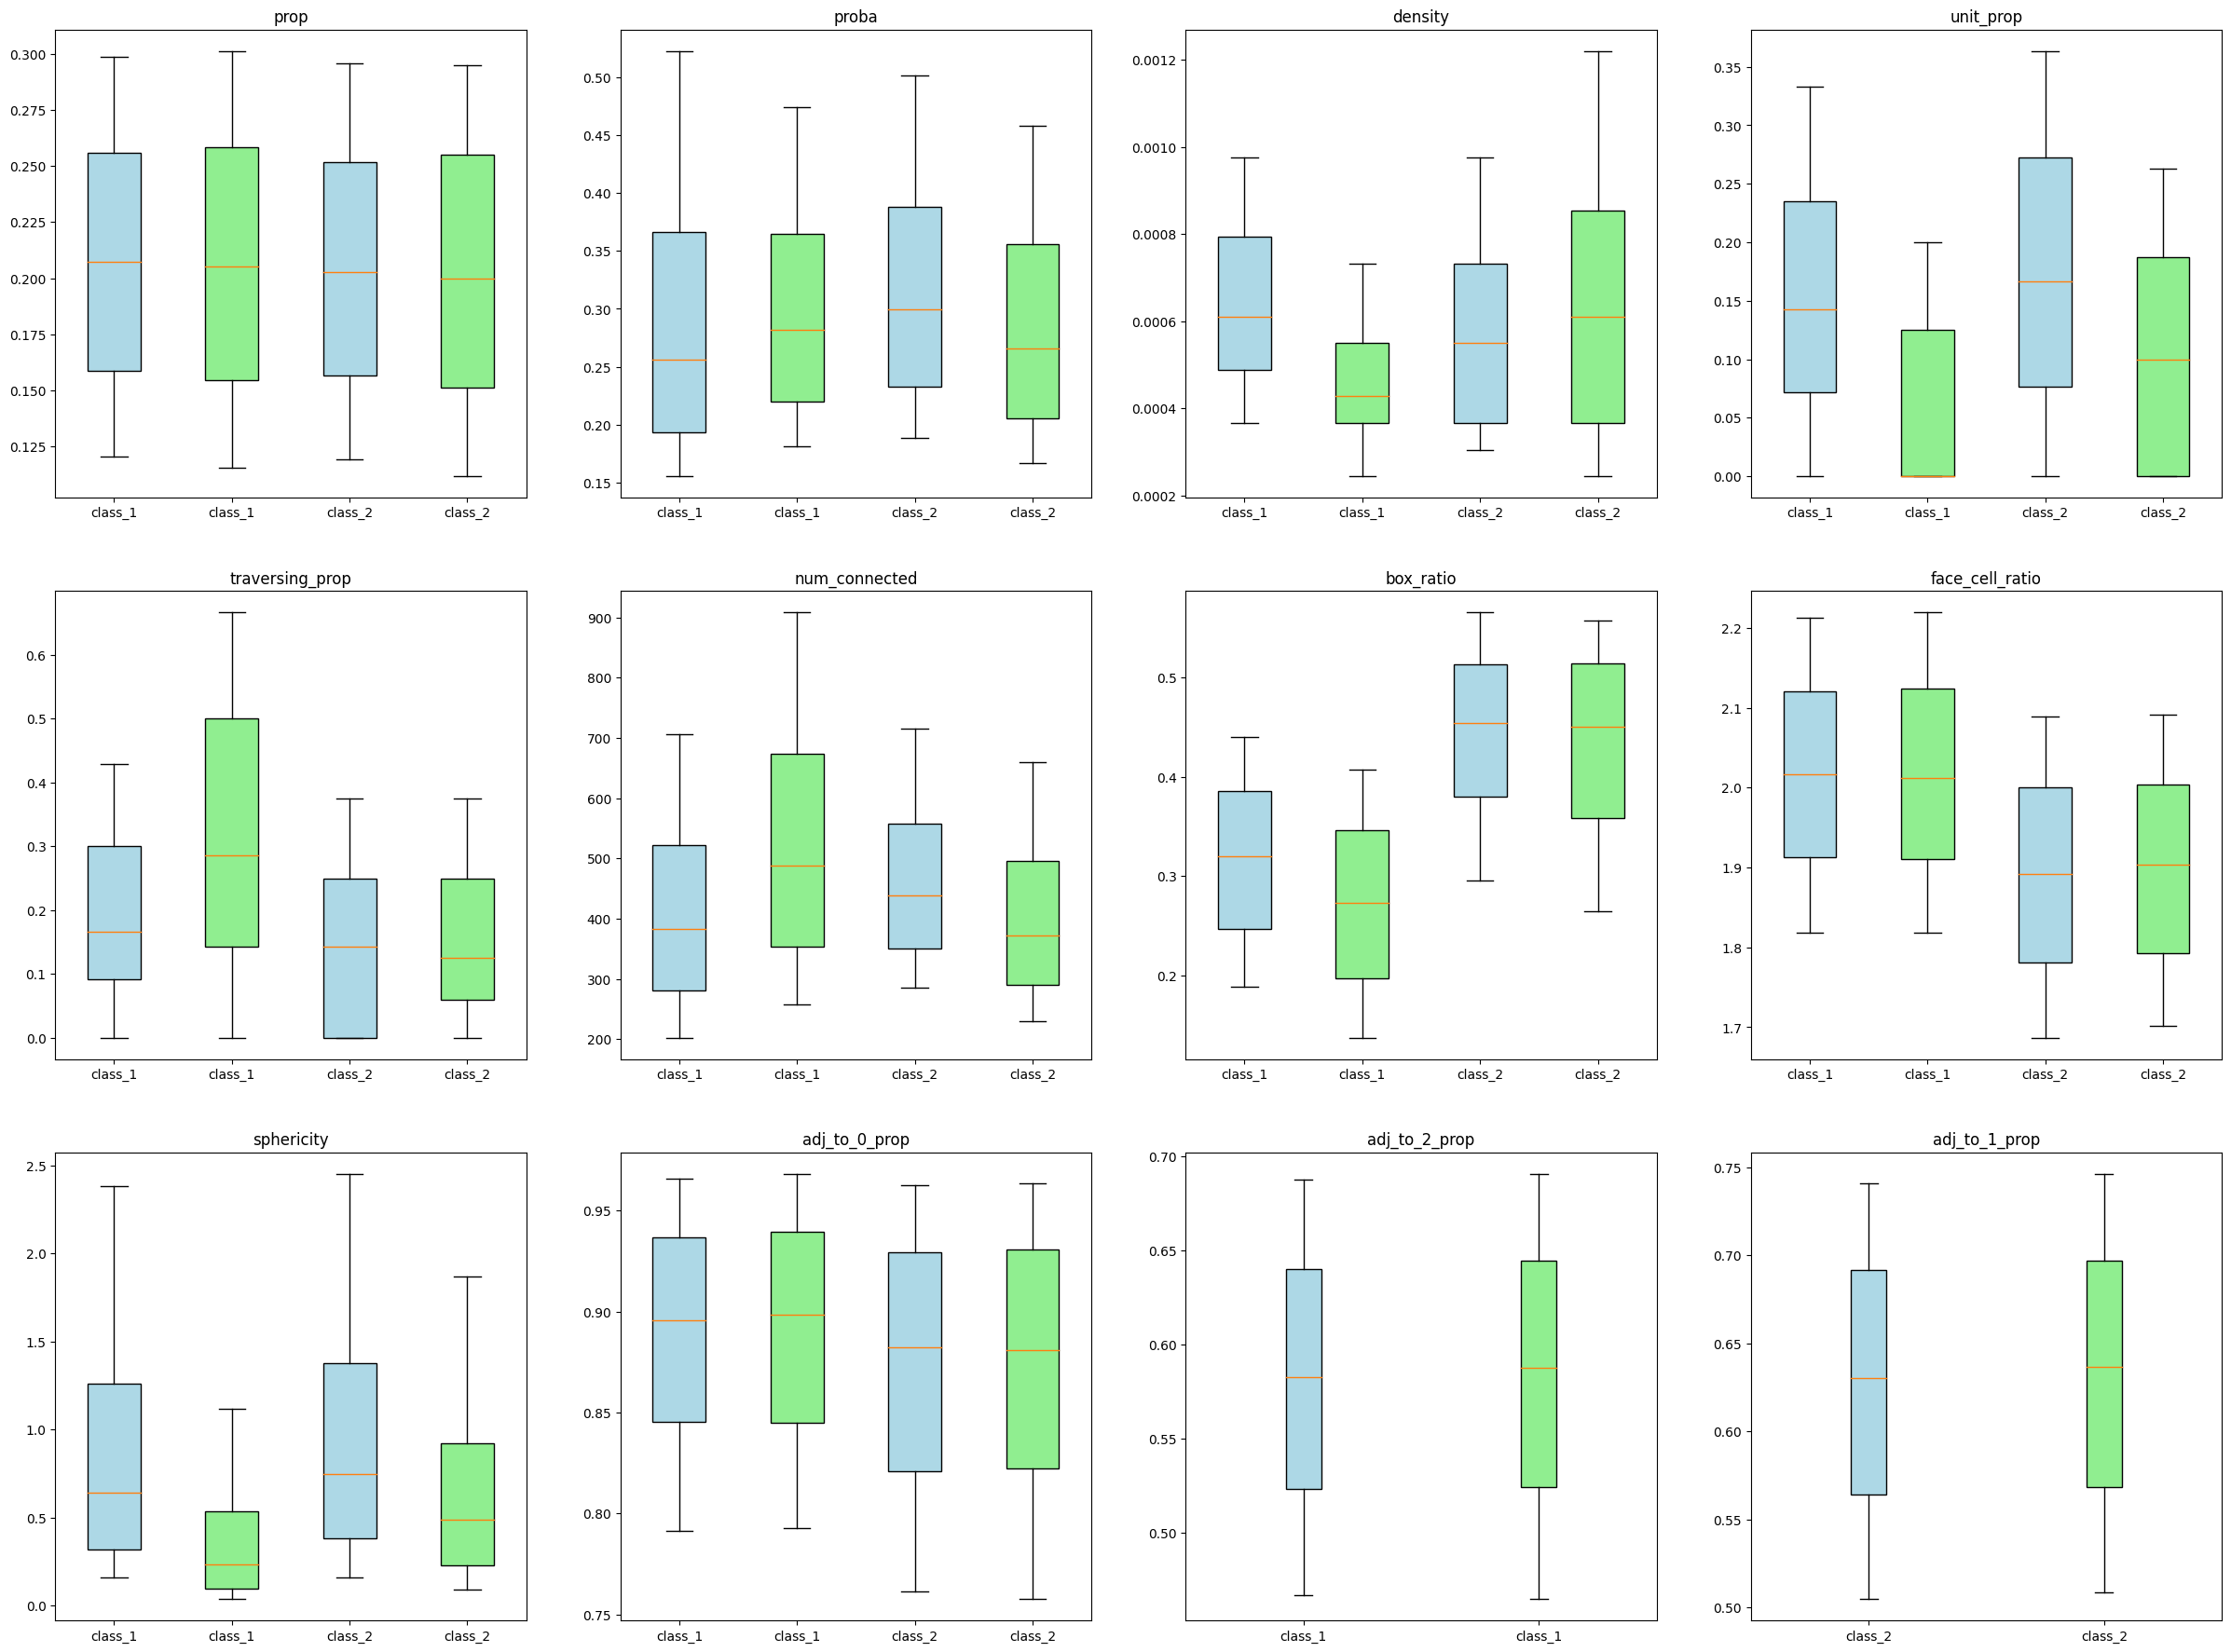

In [4]:
# Could take some minutes (faster inference on GPU)
w_dists, other_metrics, data_np, indicators = evaluate(
    gen, config, training=False, step=step,
    indicators_path=indicator_path, n_images=1024 * 5
    )

### Metrics for all the dataset

metrics for all the dataset:
{'prop_cls_1': 0.012810629140538677, 'proba_cls_1': 0.10268891076703096, 'density_cls_1': 0.3102365702736977, 'unit_prop_cls_1': 0.6938335224162615, 'traversing_prop_cls_1': 0.4933808137224663, 'num_connected_cls_1': 0.24932633697135353, 'box_ratio_cls_1': 0.1404965633783394, 'face_cell_ratio_cls_1': 0.0029783871975733477, 'sphericity_cls_1': 0.5593018880943372, 'adj_to_0_prop_cls_1': 0.002097737393492648, 'adj_to_2_prop_cls_1': 0.00611723849113557, 'prop_cls_2': 0.016649203721831214, 'proba_cls_2': 0.10804472324043844, 'density_cls_2': 0.137442947591236, 'unit_prop_cls_2': 0.41385158058114274, 'traversing_prop_cls_2': 0.05685863475737223, 'num_connected_cls_2': 0.13199361216499694, 'box_ratio_cls_2': 0.024455522272321457, 'face_cell_ratio_cls_2': 0.005941488839104774, 'sphericity_cls_2': 0.2738860924289587, 'adj_to_0_prop_cls_2': 0.0017507637170628093, 'adj_to_1_prop_cls_2': 0.007649447219456933, 'global': 0.1705360279263704}


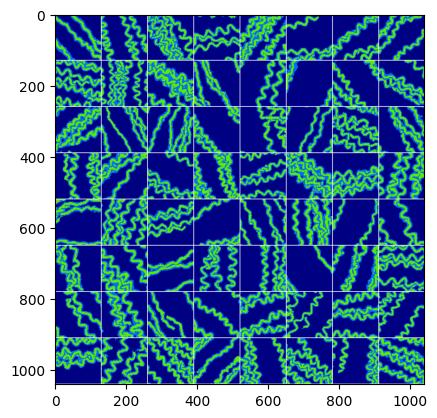

In [5]:
dists_all = wdists(indicators, indicators_ref,
                   connectivity, unit_component_size)[0]
print('metrics for all the dataset:')
print(dists_all)
color_data = color_data_np(data_np)
grid = to_img_grid(color_data)
plt.imshow(grid);

## Indicator filtering

### Alpha grid search

In [7]:
class_id = 0
indicator_name = 'density'
order = 'below'
for alpha in np.linspace(0.05, 0.95, 19):
    data_grid, indicators_grid = clip_by_indicator(data_np, indicators,
                                                   indicator_name=indicator_name,
                                                   class_id=class_id,
                                                   alpha=alpha,
                                                   order=order)

    dists_grid = wdists(indicators_grid, indicators_ref,
                        connectivity, unit_component_size)[0]
    global_metric = dists_grid['global']
    print(f'alpha {alpha:.3f}, len {len(data_grid)}, '
          f'global metrics = {global_metric:.3f}')

alpha 0.050, len 396, global metrics = 0.211
alpha 0.100, len 745, global metrics = 0.168
alpha 0.150, len 1155, global metrics = 0.147
alpha 0.200, len 1155, global metrics = 0.147
alpha 0.250, len 1631, global metrics = 0.130
alpha 0.300, len 1631, global metrics = 0.130
alpha 0.350, len 2149, global metrics = 0.128
alpha 0.400, len 2149, global metrics = 0.128
alpha 0.450, len 2698, global metrics = 0.125
alpha 0.500, len 2698, global metrics = 0.125
alpha 0.550, len 3189, global metrics = 0.126
alpha 0.600, len 3189, global metrics = 0.126
alpha 0.650, len 3628, global metrics = 0.130
alpha 0.700, len 3628, global metrics = 0.130
alpha 0.750, len 3993, global metrics = 0.133
alpha 0.800, len 4258, global metrics = 0.137
alpha 0.850, len 4481, global metrics = 0.142
alpha 0.900, len 4649, global metrics = 0.146
alpha 0.950, len 4864, global metrics = 0.150


### Pipeline

Indicator cipplings are "superposable" with each other.

len 3840
metrics {'prop_cls_1': 0.023517425675384694, 'proba_cls_1': 0.09599889487548567, 'density_cls_1': 0.27714543149046544, 'unit_prop_cls_1': 0.40811612796468655, 'traversing_prop_cls_1': 0.5263856213640496, 'num_connected_cls_1': 0.32356297544733387, 'box_ratio_cls_1': 0.20943332419094918, 'face_cell_ratio_cls_1': 0.007584727629291701, 'sphericity_cls_1': 0.39597563549344056, 'adj_to_0_prop_cls_1': 0.0014240253269540513, 'adj_to_2_prop_cls_1': 0.007481760270840091, 'prop_cls_2': 0.028444879912793822, 'proba_cls_2': 0.0954898266783784, 'density_cls_2': 0.13931652629265553, 'unit_prop_cls_2': 0.1678993819724327, 'traversing_prop_cls_2': 0.0447762275804735, 'num_connected_cls_2': 0.10330734916074273, 'box_ratio_cls_2': 0.06472166137412333, 'face_cell_ratio_cls_2': 0.005649414945805174, 'sphericity_cls_2': 0.24771992804028822, 'adj_to_0_prop_cls_2': 0.0022249568636794597, 'adj_to_1_prop_cls_2': 0.006674016512001167, 'global': 0.1446750054119207}
************
len 2091
metrics {'prop_c

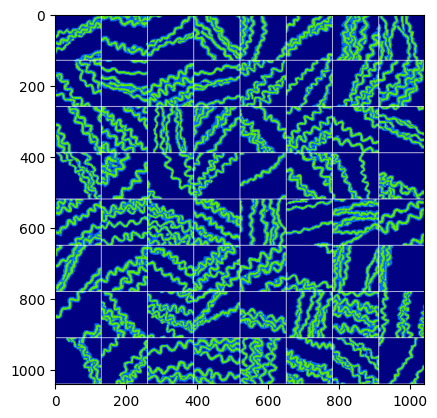

In [10]:
metrics_params = {'connectivity': connectivity,
                  'unit_component_size': unit_component_size}
data_new, indicators_new = data_np, indicators

clip_by_indicator_params = {'data': data_new,
                            'indicators': indicators_new,
                            'indicator_name': 'unit_prop',
                            'class_id': 0,
                            'alpha': 0.75,
                            'order': 'below'}
data_new, indicators_new, length, dists = clip_indicator_eval(
    indicators_ref, clip_by_indicator_params, metrics_params
    )
print(f'len {length}\nmetrics {dists}')
print('************')

clip_by_indicator_params = {'data': data_new,
                            'indicators': indicators_new,
                            'indicator_name': 'density',
                            'class_id': 0,
                            'alpha': 0.5,
                            'order': 'below'}
data_new, indicators_new, length, dists = clip_indicator_eval(
    indicators_ref, clip_by_indicator_params, metrics_params
    )

print(f'len {length}\nmetrics {dists}')
print('************')

color_data = color_data_np(data_new)
grid = to_img_grid(color_data)
plt.imshow(grid);

## OpenCV filtering

In [12]:
n_img = len(data_np)

data_new_list = []
for i in range(n_img):
    img = data_np[i]
    unique_values = list(range(img.max() + 1))
    new_img = postprocess_erode_dilate(img)
    data_new_list.append(new_img[None, ...])
    del img, new_img
    print(f'img {i + 1}/{n_img} processed', end='\r')
print()
data_new = np.vstack(data_new_list).astype(np.uint8)

img 5120/5120 processed


{'prop_cls_1': 0.01130960382068647, 'proba_cls_1': 0.0980119443859823, 'density_cls_1': 0.2788087831209353, 'unit_prop_cls_1': 0.3798911117803034, 'traversing_prop_cls_1': 0.5195543741205971, 'num_connected_cls_1': 0.29216630942104915, 'box_ratio_cls_1': 0.20476323601362317, 'face_cell_ratio_cls_1': 0.008015959580094559, 'sphericity_cls_1': 0.4650454867747148, 'adj_to_0_prop_cls_1': 0.001481288684363612, 'adj_to_2_prop_cls_1': 0.006749969310104701, 'prop_cls_2': 0.01726780395962828, 'proba_cls_2': 0.10342316427478439, 'density_cls_2': 0.14519941680728404, 'unit_prop_cls_2': 0.08338882749589037, 'traversing_prop_cls_2': 0.0544072583209137, 'num_connected_cls_2': 0.08575100214773793, 'box_ratio_cls_2': 0.069917939817891, 'face_cell_ratio_cls_2': 0.0066199284582680665, 'sphericity_cls_2': 0.17708946826077568, 'adj_to_0_prop_cls_2': 0.0018558024561804842, 'adj_to_1_prop_cls_2': 0.006432595039812307, 'global': 0.13714323972961914}


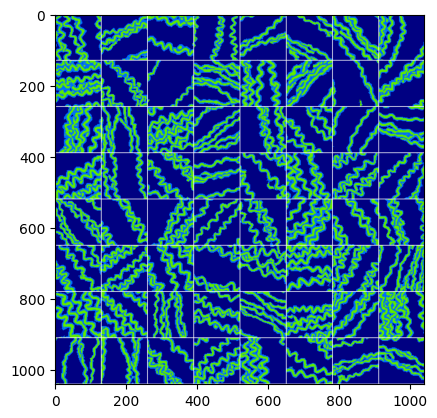

In [13]:
dists_new = wdists(data_new, indicators_ref,
                   connectivity, unit_component_size)[0]
print(dists_new)
color_data = color_data_np(data_new)
grid = to_img_grid(color_data)
plt.imshow(grid);
